# Nightly Epoch Magnitude Limits

Contact: Melissa Graham

Create an output file of nightly-epoch magnitude limits.

All images obtained on a given night for a given filter are used to calculate a mean limiting magnitude for the field (COSMOS or ELAIS).

Output file: all_nightly_epochs_files/nightly_epoch_magnitude_limits.dat

In [1]:
import psycopg2
import psycopg2.extras
import getpass
import pandas

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord

from copy import deepcopy
import time

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  decat_ro
DB Password:  ········


In [ ]:
# tables = ['versiontags','exposures','subtractions','images',\
#           'objects','objectrbs','objectdatas','objectdata_versiontag','candidates']
# tables = ['images']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

## define field centers

In [3]:
field_name = ['COSMOS-1', 'COSMOS-2', 'COSMOS-3', 'ELAIS-E1', 'ELAIS-E2']
field_sra  = ['10:00:00', '09:56:53', '10:03:07', '00:31:30', '00:38:00']
field_sdec = ['+03:06:00', '+01:45:00', '+01:45:00', '-43:00:35', '-43:59:53']

field_dra = np.zeros(5)
field_ddec = np.zeros(5)
for f in range(5):
    c = SkyCoord(field_sra[f]+' '+field_sdec[f], unit=(u.hourangle, u.deg))
    field_dra[f] = c.ra.deg
    field_ddec[f] = c.dec.deg
    print(field_name[f], field_sra[f], field_dra[f], field_sdec[f], field_ddec[f])

COSMOS-1 10:00:00 149.99999999999997 +03:06:00 3.1
COSMOS-2 09:56:53 149.2208333333333 +01:45:00 1.75
COSMOS-3 10:03:07 150.77916666666664 +01:45:00 1.75
ELAIS-E1 00:31:30 7.874999999999999 -43:00:35 -43.00972222222222
ELAIS-E2 00:38:00 9.499999999999998 -43:59:53 -43.99805555555556


## get list of images

In [4]:
t1 = time.time()

query = "SELECT id, ra, dec, lmt_mg, filter, meanmjd FROM images"
cursor.execute(query)
results = np.array(cursor.fetchall()).transpose()
img_id = np.asarray(results[0])
img_ra = np.asarray(results[1], dtype='float')
img_dec = np.asarray(results[2], dtype='float')
img_lmt_mg = np.asarray(results[3], dtype='float')
img_filter = np.asarray(results[4], dtype='str')
img_meanmjd = np.asarray(results[5], dtype='float')
del query, results
print(len(img_id))

t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))

350549
elapsed:   4.7


### image field names

In [10]:
temp = np.zeros(len(img_id), dtype='S8')

for f in range(5):
    use_fieldname = ''
    if (field_name[f] == 'COSMOS-1') | (field_name[f] == 'COSMOS-2') | (field_name[f] == 'COSMOS-3'):
        use_fieldname = 'COSMOS'
    elif (field_name[f] == 'ELAIS-E1') | (field_name[f] == 'ELAIS-E2'):
        use_fieldname = 'ELAIS'
    tx = np.where((np.abs(img_ra - field_dra[f]) < 0.1) & 
                  (np.abs(img_dec - field_ddec[f]) < 0.1))[0]
    if len(tx) > 0:
        temp[tx] = use_fieldname
    del use_fieldname

img_field = np.asarray(temp, dtype='str')
del temp
    
values, counts = np.unique(img_field, return_counts=True)
print(values)

['' 'COSMOS' 'ELAIS']


plot the ra and dec, color by field name, just to take a quick look and make sure is ok

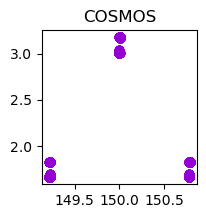

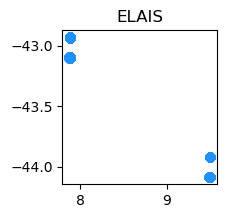

In [11]:
cx = np.where(img_field == 'COSMOS')[0]
ex = np.where(img_field == 'ELAIS')[0]
fig = plt.figure(figsize=(2, 2))
plt.plot(img_ra[cx], img_dec[cx], 'o', color='darkviolet')
plt.title('COSMOS')
plt.show()
fig = plt.figure(figsize=(2, 2))
plt.plot(img_ra[ex], img_dec[ex], 'o', color='dodgerblue')
plt.title('ELAIS')
plt.show()
del cx, ex

## create nightly epochs arrays

build up array of field, unique calendar dates in isot and mjd, filter, number of images, and the mean limiting magnitude and its error

In [12]:
temp_ne_field = []
temp_ne_cal = []
temp_ne_mjd = []
temp_ne_filt = []
temp_ne_Nimgs = []
temp_ne_lmtmg = []
temp_ne_lmtmge = []

for each field, identify the associated images

determine the unique epochs for the field

for each unique epoch, identify images in g, r, and i

for each filter, determine the mean limiting magnitude for the filter and the unique nightly epoch

use the same set of unique mjds and caldates as in create_nightly_epoch_lightcurves.ipynb

In [13]:
umjds = 59216.0 + np.arange(1000, dtype='float')
# print(umjds)

In [14]:
temp1 = 59216.0 + np.arange(1000, dtype='float') - 0.1
temp2 = Time(temp1, format='mjd')
temp3 = []
for t in range(len(temp2)):
    temp4 = temp2[t].isot
    temp3.append(temp4[0:10])
    del temp4
ucals = np.asarray(temp3, dtype='str')
del temp1, temp2, temp3
# print(ucals)

In [15]:
t1 = time.time()

for fieldname in ['COSMOS', 'ELAIS']:
    
    tx = np.where(img_field == fieldname)[0]
    print(fieldname)
    print(len(tx), ' images found')
    
    tally_ne = 0
    
    ### THE OLD WAY
    # mjds = img_meanmjd[tx]
    # temp = Time(mjds, format='mjd')
    # temp2 = temp.isot
    # temp3 = []
    # for i in temp2:
    #     temp3.append(i[0:10])
    # ucals, indices = np.unique(temp3, return_index=True)
    # print(len(ucals), ' unique nightly epochs identified')
    # umjds = mjds[indices]
    # del temp, temp2, temp3, indices
    
    for d, mjd in enumerate(umjds):
        
        for f, fil in enumerate(['g','r','i']):
            fx = np.where((mjd - 0.1 < img_meanmjd[tx]) & (img_meanmjd[tx] < mjd + 0.5) & 
                          (img_filter[tx] == fil) & 
                          (np.isfinite(img_lmt_mg[tx])) & 
                          (img_lmt_mg[tx] > 0.0))[0]

            if len(fx) >= 2:
                temp_ne_field.append(fieldname)
                temp_ne_cal.append(ucals[d])
                temp_ne_mjd.append(np.mean(img_meanmjd[tx[fx]]))
                temp_ne_filt.append(fil)
                temp_ne_Nimgs.append(len(fx))
                temp_ne_lmtmg.append(np.mean(img_lmt_mg[tx[fx]]))
                temp_ne_lmtmge.append(np.std(img_lmt_mg[tx[fx]]))
                tally_ne += 1

    print(tally_ne, ' nightly epochs & filters have usable limiting magnitudes')

t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))

COSMOS
6205  images found
244  nightly epochs & filters have usable limiting magnitudes
ELAIS
5435  images found
290  nightly epochs & filters have usable limiting magnitudes
elapsed:   1.3


create numpy arrays and delete the temporary lists

In [16]:
ne_field  = np.asarray(temp_ne_field, dtype='str')
ne_cal    = np.asarray(temp_ne_cal, dtype='str')
ne_mjd    = np.asarray(temp_ne_mjd, dtype='float')
ne_filt   = np.asarray(temp_ne_filt, dtype='str')
ne_Nimgs  = np.asarray(temp_ne_Nimgs, dtype='int')
ne_lmtmg  = np.asarray(temp_ne_lmtmg, dtype='float')
ne_lmtmge = np.asarray(temp_ne_lmtmge, dtype='float')

del temp_ne_field, temp_ne_cal, temp_ne_mjd, temp_ne_filt
del temp_ne_Nimgs, temp_ne_lmtmg, temp_ne_lmtmge

plot the distributions of nightly epoch limiting magnitudes and number of images that contributed for a given night and filter

for COSMOS it should be 5 images per pointing per filter per night, for 3 pointings, so an average of 15 images per filter

for ELAIS it should be 5 images per pointing per filter per night, for 2 pointings, so an average of 10 images per filter

it is weird that it is 20... figure it out later

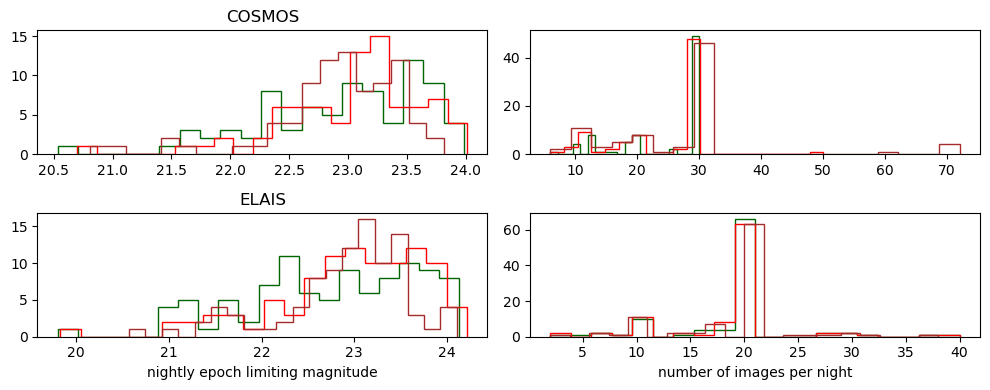

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharex=False, sharey=False)

cgx = np.where((ne_filt == 'g') & (ne_field == 'COSMOS'))[0]
crx = np.where((ne_filt == 'r') & (ne_field == 'COSMOS'))[0]
cix = np.where((ne_filt == 'i') & (ne_field == 'COSMOS'))[0]

egx = np.where((ne_filt == 'g') & (ne_field == 'ELAIS'))[0]
erx = np.where((ne_filt == 'r') & (ne_field == 'ELAIS'))[0]
eix = np.where((ne_filt == 'i') & (ne_field == 'ELAIS'))[0]

ax[0, 0].hist(ne_lmtmg[cgx], bins=20, histtype='step', color='darkgreen') # range=[[15, 25],[0.0,1.0]]
ax[0, 0].hist(ne_lmtmg[crx], bins=20, histtype='step', color='red')
ax[0, 0].hist(ne_lmtmg[cix], bins=20, histtype='step', color='brown')
ax[0, 1].hist(ne_Nimgs[cgx], bins=20, histtype='step', color='darkgreen')
ax[0, 1].hist(ne_Nimgs[crx], bins=20, histtype='step', color='red')
ax[0, 1].hist(ne_Nimgs[cix], bins=20, histtype='step', color='brown')
ax[0, 0].set_title('COSMOS')

ax[1, 0].hist(ne_lmtmg[egx], bins=20, histtype='step', color='darkgreen')
ax[1, 0].hist(ne_lmtmg[erx], bins=20, histtype='step', color='red')
ax[1, 0].hist(ne_lmtmg[eix], bins=20, histtype='step', color='brown')
ax[1, 0].set_xlabel('nightly epoch limiting magnitude')
ax[1, 1].hist(ne_Nimgs[egx], bins=20, histtype='step', color='darkgreen')
ax[1, 1].hist(ne_Nimgs[erx], bins=20, histtype='step', color='red')
ax[1, 1].hist(ne_Nimgs[eix], bins=20, histtype='step', color='brown')
ax[1, 1].set_xlabel('number of images per night')
ax[1, 0].set_title('ELAIS')

plt.tight_layout()
fig.show()

In [18]:
fnm = 'all_nightly_epochs_files/nightly_epoch_magnitude_limits.dat'
fout = open(fnm, 'w')

fout.write('# Melissa Graham, nightly_epoch_magnitude_limits.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow

fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 field \n')
fout.write('#  1 calendar date \n')
fout.write('#  2 MJD \n')
fout.write('#  3 filter \n')
fout.write('#  4 number of images combined \n')
fout.write('#  5 limitng magnitude (mean of image magnitude limits) \n')
fout.write('#  6 limitng magnitude uncertainty (std dev) \n')
fout.write('# \n')

for field in ['COSMOS', 'ELAIS']:
    tx = np.where(ne_field == field)[0]
    sx = np.argsort(ne_mjd[tx])
    for x in sx:
        fout.write('%-9s %-8s %12.6f '\
                   '%1s %3i %6.3f %6.3f \n' % \
                   (ne_field[tx[x]], ne_cal[tx[x]], ne_mjd[tx[x]], \
                    ne_filt[tx[x]], ne_Nimgs[tx[x]], ne_lmtmg[tx[x]], ne_lmtmge[tx[x]]))
    del tx, sx
    
fout.close()
print('Wrote to: ', fnm)
del fnm

Wrote to:  all_nightly_epochs_files/nightly_epoch_magnitude_limits.dat


## get list of candidates and their RA, Dec

**NOTE:** ended up not needing candidate list for this notebook, but leaving code here

get all candidates and their RA, Dec

In [ ]:
# t1 = time.time()

# query = "SELECT id, ra, dec FROM candidates"
# cursor.execute(query)
# results = np.array(cursor.fetchall()).transpose()
# cand_id = np.asarray(results[0])
# cand_ra = np.asarray(results[1], dtype='float')
# cand_dec = np.asarray(results[2], dtype='float')
# del query, results
# print(len(cand_id))

# t2 = time.time()
# print('elapsed: %5.1f' % (t2 - t1))

get just the candidates of interest, those with nightly epoch lightcurves

In [ ]:
# temp = np.loadtxt('all_nightly_epochs_files/candidate_lightcurves.dat', dtype='str', usecols=(1))
# list_cand_id = np.sort(np.unique(temp))
# print(len(list_cand_id))
# del temp

do a fast sort-and-match to get RA, Dec for candidates of interest

In [ ]:
# t1 = time.time()

# list_cand_ra = np.zeros(len(list_cand_id), dtype='float')
# list_cand_dec = np.zeros(len(list_cand_id), dtype='float')

# sx = np.argsort(cand_id)
# sxi = 0

# for c, cid in enumerate(list_cand_id):
#     while cid != cand_id[sx[sxi]]:
#         sxi += 1
#     list_cand_ra[c] = cand_ra[sx[sxi]]
#     list_cand_dec[c] = cand_dec[sx[sxi]]
#     # print(c, cid, sxi, sx[sxi], cand_id[sx[sxi]])

# t2 = time.time()
# print('elapsed: %5.1f' % (t2 - t1))

delete arrays not needed anymore

In [ ]:
# del cand_id, cand_ra, cand_dec